In [1]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

Using TensorFlow backend.


In [2]:
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

(None, 224, 224, 3)
(224, 224)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


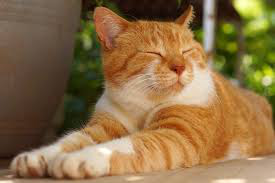

In [3]:
# we start from a path / URI.
# If you already have an image loaded, follow the subsequent steps
image = '/home/nitin/Pictures/download.jpeg'

# this is the original "cat dog" image used in the Grad-CAM paper
# check the image with Pillow
im = Image.open(image)
print(type(im))
display(im)

<class 'PIL.Image.Image'>


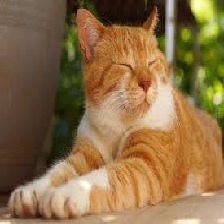

In [4]:
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
im = keras.preprocessing.image.load_img(image, target_size=dims) # -> PIL image
print(type(im))
display(im)

In [5]:
# we use a routine from `keras.preprocessing` for that as well
# we get a 'doc', an object almost ready to be inputted into the model

doc = keras.preprocessing.image.img_to_array(im) # -> numpy array
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [6]:
# dimensions are looking good
# except that we are missing one thing - the batch size

# we can use a numpy routine to create an axis in the first position
doc = np.expand_dims(doc, axis=0)
print(type(doc), doc.shape)


<class 'numpy.ndarray'> (1, 224, 224, 3)


In [7]:
# one last thing
# `keras.applications` models come with their own input preprocessing function
# for best results, apply that as well

# mobilenetv2-specific preprocessing
# (this operation is in-place)
mobilenet_v2.preprocess_input(doc)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


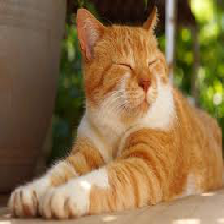

In [8]:
# take back the first image from our 'batch'
display(keras.preprocessing.image.array_to_img(doc[0]))

In [9]:
# make a prediction about our sample image
predictions = model.predict(doc)
print(type(predictions), predictions.shape)

<class 'numpy.ndarray'> (1, 1000)


In [10]:
# check the top 5 indices
# `keras.applications` contains a function for that

top = mobilenet_v2.decode_predictions(predictions)
top_indices = np.argsort(predictions)[0, ::-1][:5]

print(top)
print(top_indices)

[[('n02123159', 'tiger_cat', 0.61396223), ('n02123045', 'tabby', 0.23474504), ('n02124075', 'Egyptian_cat', 0.060375948), ('n02127052', 'lynx', 0.008879163), ('n02123597', 'Siamese_cat', 0.0038481203)]]
[282 281 285 287 284]


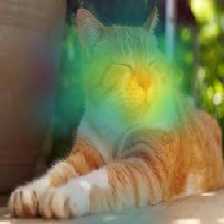

In [11]:
eli5.show_prediction(model, doc)

In [12]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
# we could use model.summary() here, but the model has over 100 layers.
# we will only look at the first few and last few layers

head = model.layers[:5]
tail = model.layers[-8:]

def pretty_print_layers(layers):
    for l in layers:
        info = [l.name, type(l).__name__, l.output_shape, l.count_params()]
        pretty_print(info)

def pretty_print(lst):
    s = ',\t'.join(map(str, lst))
    print(s)

pretty_print(['name', 'type', 'output shape', 'param. no'])
print('-'*100)
pretty_print([model.input.name, type(model.input), model.input_shape, 0])
pretty_print_layers(head)
print()
print('...')
print()
pretty_print_layers(tail)

name,	type,	output shape,	param. no
----------------------------------------------------------------------------------------------------
input_1:0,	<class 'tensorflow.python.framework.ops.Tensor'>,	(None, 224, 224, 3),	0
input_1,	InputLayer,	(None, 224, 224, 3),	0
Conv1_pad,	ZeroPadding2D,	(None, 225, 225, 3),	0
Conv1,	Conv2D,	(None, 112, 112, 32),	864
bn_Conv1,	BatchNormalization,	(None, 112, 112, 32),	128
Conv1_relu,	ReLU,	(None, 112, 112, 32),	0

...

block_16_depthwise_relu,	ReLU,	(None, 7, 7, 960),	0
block_16_project,	Conv2D,	(None, 7, 7, 320),	307200
block_16_project_BN,	BatchNormalization,	(None, 7, 7, 320),	1280
Conv_1,	Conv2D,	(None, 7, 7, 1280),	409600
Conv_1_bn,	BatchNormalization,	(None, 7, 7, 1280),	5120
out_relu,	ReLU,	(None, 7, 7, 1280),	0
global_average_pooling2d_1,	GlobalAveragePooling2D,	(None, 1280),	0
Logits,	Dense,	(None, 1000),	1281000


block_2_expand


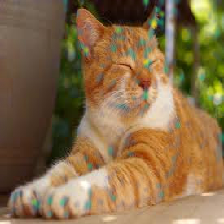

block_9_expand


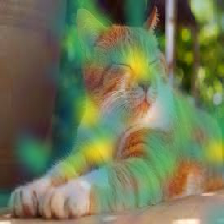

Conv_1


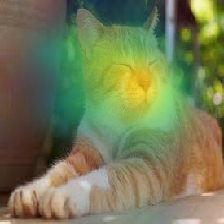

In [14]:
for l in ['block_2_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument

In [15]:
expl = eli5.explain_prediction(model, doc)

In [16]:
print(expl)

Explanation(estimator='mobilenetv2_1.00_224', description='Grad-CAM visualization for image classification; \noutput is explanation object that contains input image \nand heatmap image for a target.\n', error='', method='Grad-CAM', is_regression=False, targets=[TargetExplanation(target=282, feature_weights=None, proba=None, score=0.61396223, weighted_spans=None, heatmap=array([[1.58613444e-03, 4.44975318e-03, 3.44010490e-01, 4.30683231e-01,
        4.77314358e-01, 1.97708733e-01, 0.00000000e+00],
       [0.00000000e+00, 3.36587894e-01, 6.29055867e-01, 6.34312135e-01,
        6.44010448e-01, 6.00705405e-01, 2.68767505e-02],
       [0.00000000e+00, 2.23913142e-01, 6.80349236e-01, 8.43225165e-01,
        9.99999896e-01, 7.92426133e-01, 0.00000000e+00],
       [0.00000000e+00, 4.41120897e-01, 5.80518701e-01, 6.45548639e-01,
        8.69449788e-01, 6.82968778e-01, 8.76744082e-03],
       [3.04967193e-02, 0.00000000e+00, 1.36438195e-01, 4.32672803e-01,
        3.95739397e-01, 2.07892208e-02,

In [17]:
print((expl.targets[0].target, expl.targets[0].score, expl.targets[0].proba))

(282, 0.61396223, None)


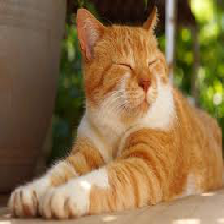

[[1.58613444e-03 4.44975318e-03 3.44010490e-01 4.30683231e-01
  4.77314358e-01 1.97708733e-01 0.00000000e+00]
 [0.00000000e+00 3.36587894e-01 6.29055867e-01 6.34312135e-01
  6.44010448e-01 6.00705405e-01 2.68767505e-02]
 [0.00000000e+00 2.23913142e-01 6.80349236e-01 8.43225165e-01
  9.99999896e-01 7.92426133e-01 0.00000000e+00]
 [0.00000000e+00 4.41120897e-01 5.80518701e-01 6.45548639e-01
  8.69449788e-01 6.82968778e-01 8.76744082e-03]
 [3.04967193e-02 0.00000000e+00 1.36438195e-01 4.32672803e-01
  3.95739397e-01 2.07892208e-02 3.21825182e-02]
 [0.00000000e+00 0.00000000e+00 1.27416852e-01 1.34729557e-01
  2.06837334e-01 2.93923457e-02 0.00000000e+00]
 [9.34172458e-04 0.00000000e+00 3.39883925e-01 4.01110382e-01
  3.95895715e-01 7.11067861e-02 6.30126222e-03]]


In [18]:
image = expl.image
heatmap = expl.targets[0].heatmap

display(image) # the .image attribute is a PIL image
print(heatmap) # the .heatmap attribute is a numpy array

In [19]:
heatmap_im = eli5.formatters.image.heatmap_to_image(heatmap)
display(heatmap_im)

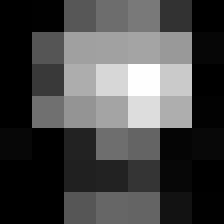

In [20]:
heatmap_im = eli5.formatters.image.expand_heatmap(heatmap, image, resampling_filter=Image.BOX)
display(heatmap_im)

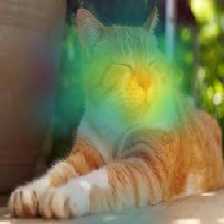

In [21]:
I = eli5.format_as_image(expl)
display(I)

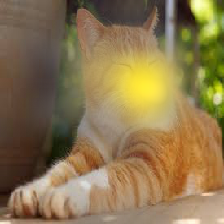

In [22]:
import matplotlib.cm

I = eli5.format_as_image(expl, alpha_limit=1.0, colormap=matplotlib.cm.cividis)
display(I)

with softmax


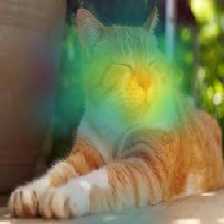

without softmax


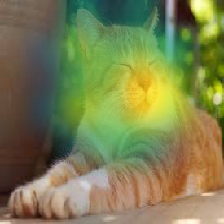

In [23]:
# first check the explanation *with* softmax
print('with softmax')
display(eli5.show_prediction(model, doc))


# remove softmax
l = model.get_layer(index=-1) # get the last (output) layer
l.activation = keras.activations.linear # swap activation

# save and load back the model as a trick to reload the graph
model.save('tmp_model_save_rmsoftmax') # note that this creates a file of the model
model = keras.models.load_model('tmp_model_save_rmsoftmax')

print('without softmax')
display(eli5.show_prediction(model, doc))

mobilenetv2_1.00_224


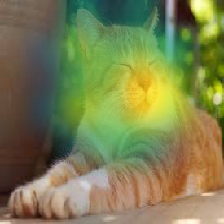

NASNet


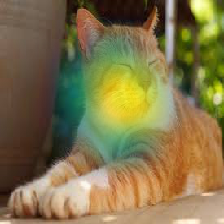

In [24]:
from keras.applications import nasnet

model2 = nasnet.NASNetMobile(include_top=True, weights='imagenet', classes=1000)

# we reload the image array to apply nasnet-specific preprocessing
doc2 = keras.preprocessing.image.img_to_array(im)
doc2 = np.expand_dims(doc2, axis=0)
nasnet.preprocess_input(doc2)

print(model.name)
display(eli5.show_prediction(model, doc))
print(model2.name)
display(eli5.show_prediction(model2, doc2))